In [1]:
import warnings
warnings.filterwarnings('ignore')

import asyncio
import numpy as np
import pandas as pd
import fsspec
from fsspec.implementations.asyn_wrapper import AsyncFileSystemWrapper
import gc
import huggingface_hub.utils
import io
import sklearn.metrics
import os
from pathlib import Path
import seaborn as sns
from tqdm.auto import tqdm, trange

In [2]:
tqdm.pandas()

In [3]:
fs_hf = AsyncFileSystemWrapper(fsspec.filesystem("hf"))
files_dataset = sorted(entry for entry in await fs_hf._glob("datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/*.parquet"))
len(files_dataset)

179

In [4]:
dir_cache = Path("work")
dir_batches = dir_cache / "batches"
dir_batches.mkdir(parents=True, exist_ok=True)
dir_embeddings = dir_cache / "embeddings"
dir_embeddings.mkdir(parents=True, exist_ok=True)
dir_metadata = dir_cache / "metadata"
dir_metadata.mkdir(parents=True, exist_ok=True)

In [5]:
path_dataset_meta = dir_cache / "dataset_meta.parquet"
if path_dataset_meta.is_file():
    dataset_meta = pd.read_parquet(path_dataset_meta)
else:
    dataset_meta = pd.DataFrame(data=[], columns=["file", "num_records"]).set_index("file").reindex(files_dataset, fill_value=np.inf)
dataset_meta

,num_records
file,
datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/0000.parquet,100000
datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/0001.parquet,100000
datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/0002.parquet,100000
datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/0003.parquet,100000
datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/0004.parquet,100000
...,...
datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/0174.parquet,100000
datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/0175.parquet,100000
datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/0176.parquet,100000


In [6]:
path_embeddings_fr = dir_cache / "embeddings-fr.npy"
path_metadata_fr = dir_cache / "metadata-fr.parquet"

In [7]:
if path_embeddings_fr.is_file() and path_metadata_fr.is_file():
    dataset_meta["num_records"] = 0
else:
    for path_info_batch in tqdm(sorted(dir_batches.iterdir()), desc="Reviewing dataset munging progress"):
        path_embeddings = dir_embeddings / path_info_batch.with_suffix(".npy").name
        path_metadata = dir_metadata / path_info_batch.name
        if not path_embeddings.is_file() or not path_metadata.is_file() or (
            np.load(path_embeddings).shape[0] != pd.read_parquet(path_metadata).shape[0]
        ):
            raise RuntimeError(
                f"An earlier processing issue has made the intermediate results in {dir_intermediate} incoherent. "
                f"My advice is to destroy directory {dir_cache} and restart the data processing from scratch."
            )
        info_batch = pd.read_parquet(path_info_batch).reindex(dataset_meta.index, fill_value=0.)
        dataset_meta -= info_batch
dataset_meta

,num_records
file,
datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/0000.parquet,0
datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/0001.parquet,0
datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/0002.parquet,0
datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/0003.parquet,0
datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/0004.parquet,0
...,...
datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/0174.parquet,0
datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/0175.parquet,0
datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3/fr/0176.parquet,0


In [8]:
files_process = sorted(dataset_meta.loc[dataset_meta["num_records"] > 0.9].index)
print(f"So far, we have crunched {len(files_dataset) - len(files_process)} files out of the dataset's {len(files_dataset)}")
len(files_process)

So far, we have crunched 179 files out of the dataset's 179


0

Now we need to compute this data for each page. That's a very large groupby operation and follow on calculations. Since we are using dask this is tractable, but it will be very time consuming.

In [9]:
async def read_dataset_file(path):
    return pd.read_parquet(io.BytesIO(await fs_hf._cat(path)))

In [10]:
async def iter_data_by_title(files, chunk_size=10000):
    data_in_hand = pd.DataFrame(data=[], columns=["_id", "url", "title", "text", "emb"]).set_index("title")
    for file in tqdm(files_process, "Dataset files to process"):
        partition = (await read_dataset_file(file)).assign(file=file)
        dataset_meta.loc[file]["num_records"] = len(partition)
        dataset_meta.to_parquet(dir_cache / "dataset_meta.parquet")

        data_in_hand = pd.concat([data_in_hand, partition.set_index("title")])
        while True:
            index_u = data_in_hand.index.unique()
            if len(index_u) < chunk_size:
                break
            yield data_in_hand.loc[index_u[:chunk_size]]
            data_in_hand = data_in_hand.drop(index=index_u[:chunk_size])

        gc.collect()
    yield data_in_hand

In [11]:
def munge_article(article):
    embeddings_all = np.vstack(article["emb"])

    if len(article) < 2:
        topical_sentence = ""
    else:
        embeddings_tail = embeddings_all[1:]
        distances = sklearn.metrics.pairwise_distances([np.mean(embeddings_tail, axis=0)], embeddings_tail).squeeze()
        closest_idx = np.argmin(distances)
        topical_sentence = article["text"].iloc[1:].iloc[closest_idx]

    return pd.Series({
        "embeddings": np.mean(embeddings_all, axis=0),
        "lead_sentences": article["text"].iloc[0],
        "topical_sentences": topical_sentence,
        "word_counts": article["text"].str.split().map(len).sum()
    })

In [12]:
async def munge_batch(i, batch):
    pages = batch.groupby("title").apply(munge_article).reset_index().rename(columns={"title": "titles"})
    np.save(dir_embeddings / f"{i:04d}.npy", np.vstack(pages["embeddings"]))
    pages[["titles", "lead_sentences", "topical_sentences", "word_counts"]].to_parquet(dir_metadata / f"{i:04d}.parquet", compression="zstd")
    info_batch = batch.groupby("file").agg({"text": "count"}).rename(columns={"text": "num_records"})
    assert info_batch["num_records"].sum() == batch.shape[0]
    batch.groupby("file").agg({"text": "count"}).rename(columns={"text": "num_records"}).to_parquet(dir_batches / f"{i:04d}.parquet")
    return i

In [13]:
tasks = []
try:
    id_batch = 0
    async for batch in iter_data_by_title(files_process[:10]):
        tasks.append(asyncio.create_task(munge_batch(id_batch, batch)))
        id_batch += 1
        del batch

        while True:
            not_done = []
            for task in tasks:
                if task.done():
                    if task.exception():
                        raise task.exception()
                    else:
                        del task
                else:
                    not_done.append(task)

            tasks = not_done
            if len(tasks) < 10:
                break

            # Merely wait for the next task completion, then rechecka the task queue.
            async for task in as_completed(tasks):
                break

        gc.collect()
finally:
    for task in tasks:
        task.cancel()

Dataset files to process: 0it [00:00, ?it/s]

Since we just did a lot of work, let's be sure to save the results, and set it up so that if we run this again later we can simply load the cached results rather than recomputing things...

In [14]:
if not all(p.exists() for p in [path_embeddings_fr, path_metadata_fr]):
    np.save(
        path_embeddings_fr,
        np.vstack([
            np.load(path)
            for path in tqdm(sorted(dir_embeddings.iterdir()), desc="Embeddings consolidation")
        ])
    )
    gc.collect()
    pd.concat(
        [pd.read_parquet(path) for path in tqdm(sorted(dir_metadata.iterdir()), desc="Metadata consolidation")],
        ignore_index=True
    ).to_parquet(path_metadata_fr, compression="zstd")
    gc.collect()

In [15]:
data_vectors = np.load(path_embeddings_fr)
metadata_fr = pd.read_parquet(path_metadata_fr)
metadata_fr

,titles,lead_sentences,topical_sentences,word_counts
0,(145480) 2005 TB190,"En 2010, le flux thermique de dans l'infrarou...",", appelé provisoirement 2005 TB190, est un obj...",132
1,(307616) 2003 QW90,est un objet classique de la ceinture de Kuipe...,,23
2,(35334) Yarkovsky,(35334) Yarkovsky () est un astéroïde de la ce...,,20
3,(4328) Valina,(4328) Valina est un astéroïde de la ceinture ...,,19
4,(4329) Miró,(4329) Miró (pour Joan Miró) ou (4329) 1982 SX...,,34
...,...,...,...,...
2320223,𝼛,"𝼛, appelé O barré crochet rétroflexe souscrit ...",,43
2320224,𝼝,Le c hameçon rétroflexe peut être représenté a...,"𝼝 (uniquement en minuscule), appelé c hameçon ...",77
2320225,𝼞,"𝼞, appelé s bouclé, est un symbole phonétique ...",Le s bouclé est utilisé par certains auteurs p...,76
2320226,𞟠,L'écriture éthiopienne est un alphasyllabaire ...,𞟠 (« hhyä » ou « ḥyä ») est un caractère utili...,100


## Dimension reduction

We are going to need a low dimensional representation for our map. I have my biases in this but let's demonstrate that the tooling that this is a tech-demo for (Toponymy and DataMapPlot) are completely agnostic to how you get your low-dimensional representation and use openTSNE.

In [16]:
import openTSNE
import datashader.mpl_ext
import matplotlib.pyplot as plt
import matplotlib.colors

As before we'll make sure we save off results so we don't have to redo expensive calculations again...

In [17]:
%%time
path_datamap = dir_cache / "wikipedia-fr-cohere-embed-datamap.npy"
if not path_datamap.exists():
    data_map = openTSNE.TSNE(exaggeration=3., metric="cosine", n_jobs=os.cpu_count(), n_iter=4000, verbose=True).fit(data_vectors)
    np.save(path_datamap, data_map)

CPU times: user 49 μs, sys: 14 μs, total: 63 μs
Wall time: 69.1 μs


In [18]:
data_map = np.load(path_datamap)

And let's have a quick plot to make sure we have something reasonable looking to work with.

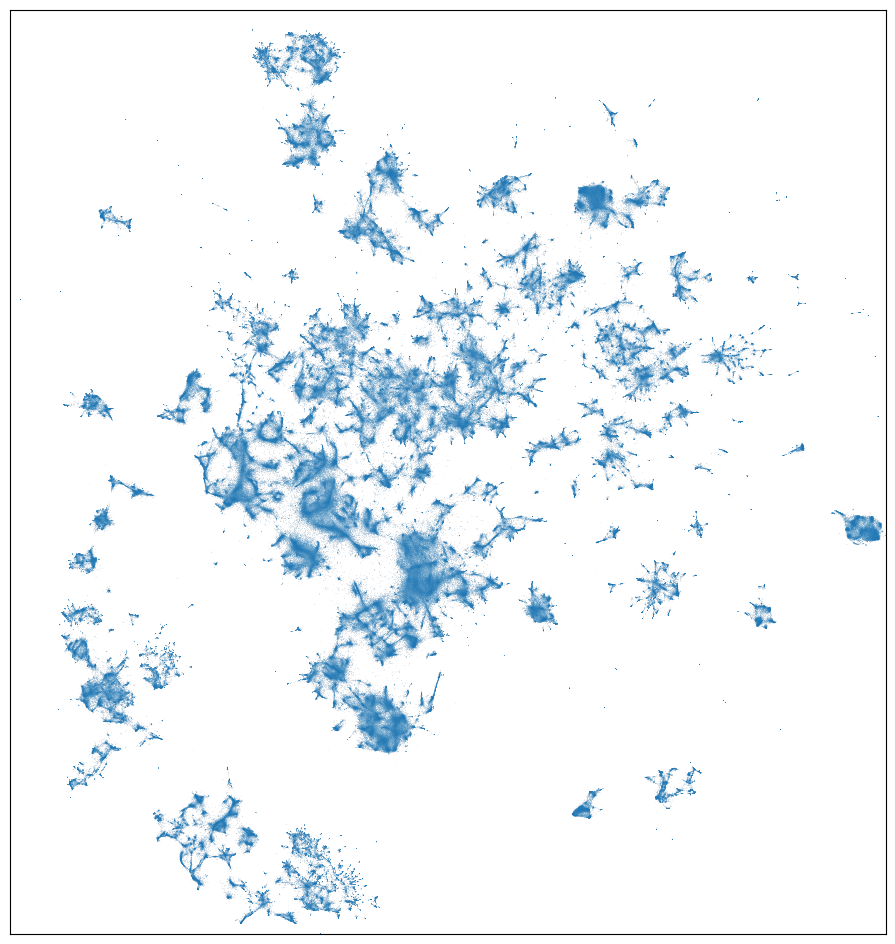

In [19]:
fig, ax = plt.subplots(figsize=(12,12))
datashader.mpl_ext.dsshow(pd.DataFrame({"x":data_map[:, 0], "y":data_map[:, 1]}), datashader.Point('x', 'y'), aspect="equal", ax=ax, norm="eq_hist",
                          cmap=sns.color_palette("light:"+str([matplotlib.colors.rgb2hex(x) for x in sns.color_palette("tab10", 1)][0]), as_cmap=True))
_ = ax.set(xticks=[], yticks=[])

## Topic Modelling

For topic modelling we are going to use Toponymy. To do that we will need some text content associated to each page. We can create that by gluing together the title, first sentence, and a topical sentence for each page. Let's do that now, ensuring we get everything lined up in the same order.

In [20]:
%%time
def shorten(sentence):
    return (
        sentence[:2045] + "..."
        if len(sentence) >= 2048
        else sentence
    )

documents = (
    metadata_fr["titles"] + "\n\n"
    + metadata_fr["lead_sentences"].progress_map(shorten)
    + "\n...\n"
    + metadata_fr["topical_sentences"].progress_map(shorten)
    + "\n...\n"
)
documents

  0%|          | 0/2320228 [00:00<?, ?it/s]

  0%|          | 0/2320228 [00:00<?, ?it/s]

CPU times: user 4.34 s, sys: 1.36 s, total: 5.7 s
Wall time: 5.69 s


0          (145480) 2005 TB190\n\nEn 2010, le flux thermi...
1          (307616) 2003 QW90\n\nest un objet classique d...
2          (35334) Yarkovsky\n\n(35334) Yarkovsky () est ...
3          (4328) Valina\n\n(4328) Valina est un astéroïd...
4          (4329) Miró\n\n(4329) Miró (pour Joan Miró) ou...
                                 ...                        
2320223    𝼛\n\n𝼛, appelé O barré crochet rétroflexe sous...
2320224    𝼝\n\nLe c hameçon rétroflexe peut être représe...
2320225    𝼞\n\n𝼞, appelé s bouclé, est un symbole phonét...
2320226    𞟠\n\nL'écriture éthiopienne est un alphasyllab...
2320227    🜨\n\nCe symbole relativement simple (une croix...
Length: 2320228, dtype: object

Now we need to import Toponymy and the associated bits and pieces from it to do this. In particular we are going to need access to an LLM, and an embedding model. Since I had access to Cohere models running on Azure AI Foundry I am going to use those. You will need to make use of whatever services (or local models) you wish. For reference Toponymy supports using any of Cohere, OpenAI, Anthropic, and AzureAI for LLM services, or llama_cpp or Huggingface for running LLMs locally (you'll want a GPU for that). For embedding you can use any SentenceTransformer model (but you'll likely want a GPU) or embedding services from AzureAI, Cohere, and others. Toponymy also has Async versions of most of the llm_wrappers which batch queries adn can run a lot faster (depending on your service rate limits). Those had not been fully implemented when I first ran this, so I will stick with the approach I used at the time. If you want to speed things up I recommend exploring the Async llm_warppers.

In [21]:
from toponymy import Toponymy, ToponymyClusterer, KeyphraseBuilder, ClusterLayerText
from toponymy.llm_wrappers import AsyncAzureAI, AzureAI
from toponymy.embedding_wrappers import AzureAIEmbedder

Obviously you'll need to load your own API keys here ...

In [21]:
%load_ext dotenv
%dotenv
from getpass import getpass
try:
    azure_api_key = os.environ["AZURE_COHERE_API_KEY"]
except KeyError:
    azure_api_key = getpass("Copy-paste your API key here:")
    Path(".env").write_text(f'AZURE_COHERE_API_KEY = "{azure_api_key}"\n', encoding="utf-8")
    print("It's saved to local file .env for future runs.")

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
cannot find .env file


Copy-paste your API key here: ········


It's saved to local file .env for future runs.


Now we'll instantiate the llm, embedding model, clusterer and keyphrase builder that Toponymy will use. You will have to swap in your preferred services or local models here, but the clusterer and keyphrase builder should be fine as is.

In [22]:
llm = AsyncAzureAI(
    api_key=azure_api_key,
    endpoint="https://azureaitimcuse5821437469.services.ai.azure.com/models",
    model="Cohere-command-r-08-2024",
    llm_specific_instructions="Topic names should be in français not English",
)
embedding_model = AzureAIEmbedder(api_key=azure_api_key, endpoint="https://azureaitimcuse5821437469.services.ai.azure.com/models", model="Cohere-embed-v3-multilingual")
clusterer = ToponymyClusterer(min_clusters=8, base_n_clusters=16000, verbose=True)
keyphrase_builder = KeyphraseBuilder(verbose=True, n_jobs=16)

We can now create a topic modeller as a Toponymy object. It helps to provide a description of the objects (documents) and corpus as this will aid in providing more accurate names. In our case that's straightforward since we are working with Wikipedia.

In [23]:
topic_namer = Toponymy(
    llm,
    embedding_model,
    clusterer=clusterer,
    keyphrase_builder=keyphrase_builder,
    object_description='Wikipedia article title and excerpt',
    corpus_description='English language Wikipedia',
    show_progress_bars=True,
)

<div class="alert alert-block alert-danger">Running the next cell will start the topic naming process. This will take a long time, and more importantly, if you are using an LLM service cost you <b>actual money</b>. I have run a similar workload to this using Claude-Haiku-3, and it cost around $15, but a lot will depend on the service and model you select. As a general rule the cheapest LLMs available from Anthropic, OpenAI, and Cohere are generally powerful enough to do a good job, and you get significantly diminishing returns for more expensive models.</div>

As usual we are going to save off results here so we don't have to rerun this all later.

In [24]:
%%time
if all((dir_cache / f"wikipedia_fr_azureai_2025-05_topic_layer_{i}.npy").is_file() for i in range(7)):
    print("Reading results from disk...")
    topic_layers = []
    for i in range(7):
        topic_layers.append(np.load(dir_cache / f"wikipedia_fr_azureai_2025-05_topic_layer_{i}.npy", allow_pickle=True))
else:
    topic_namer.fit(documents, data_vectors, data_map, exemplar_method="central")

    for i, layer in enumerate(topic_namer.topic_name_vectors_):
        np.save(dir_cache / f"wikipedia_fr_azureai_2025-05_topic_layer_{i}.npy", layer)
    topic_layers = topic_namer.topic_name_vectors_

Layer 0 found 16236 clusters
Layer 1 found 4480 clusters
Layer 2 found 1304 clusters
Layer 3 found 398 clusters
Layer 4 found 122 clusters
Layer 5 found 40 clusters
Layer 6 found 11 clusters
Building keyphrase matrix ... 
Chunking into 16 chunks of size 145015 for keyphrase identification.
Combining count dictionaries ...
Found 50000 keyphrases.
Chunking into 16 chunks of size 145015 for keyphrase count construction.
Combining count matrix chunks ...


Selecting central exemplars:   0%|          | 0/16236 [00:00<?, ?cluster/s]

embedding texts:   0%|          | 0/521 [00:00<?, ?it/s]

Building topic names by layer:   0%|          | 0/7 [00:00<?, ?layer/s]

Generating informative keyphrases:   0%|          | 0/16236 [00:00<?, ?cluster/s]

Generating prompts for layer 0:   0%|          | 0/16236 [00:00<?, ?topic/s]

CPU times: user 42min 14s, sys: 27.4 s, total: 42min 42s
Wall time: 3h 49min 56s


KeyboardInterrupt: 

**Note:** the async LLM wrapper hung up at some point. It seems like the coroutine either never finished, or left stuff hanging that made `run_until_complete` hang.

## Visualizing the Data Map

This is the real goal here -- making useful visualizations of the entire content of English Wikipedia. For that we are going to use datamapplot. Since we'll be building an interactive version in due course we'll also need to import the selection_handlers module.

In [25]:
import datamapplot
import datamapplot.selection_handlers

Since Cohere did a lot of the heavy lifting for us (providing embeddings of all the text on Wikipedia and releasing that as an accessible dataset, as well as helping out with topic modelling) let's grab the Cohere logo that we can stick on our plot.

In [26]:
import requests
import PIL
cohere_logo_response = requests.get(
    "https://asset.brandfetch.io/idfDTLvPCK/idyv4d98RT.png",
    stream=True,
)
cohere_logo = np.asarray(PIL.Image.open(cohere_logo_response.raw))

Before embarking on an interactive plot, let's make a static plot so we can check that we have something reasonable here. We'll use the topic layer 5 for topic labels, since this is one layer down from the uppermost labels (which will likely be few and fairly high level), but not so far down as to be in the weeds of Wikipedia with far too many far too detailed topics. Beyond that it is a matter of adding some aesthetic styling with DataMapPlot -- we'll make the topic indicator arrows a little more stylish, Choose a nice font, and pick out a more interesting background colour.

Calculating medoids: 100%|██████████| 40/40 [00:13<00:00,  3.07it/s]


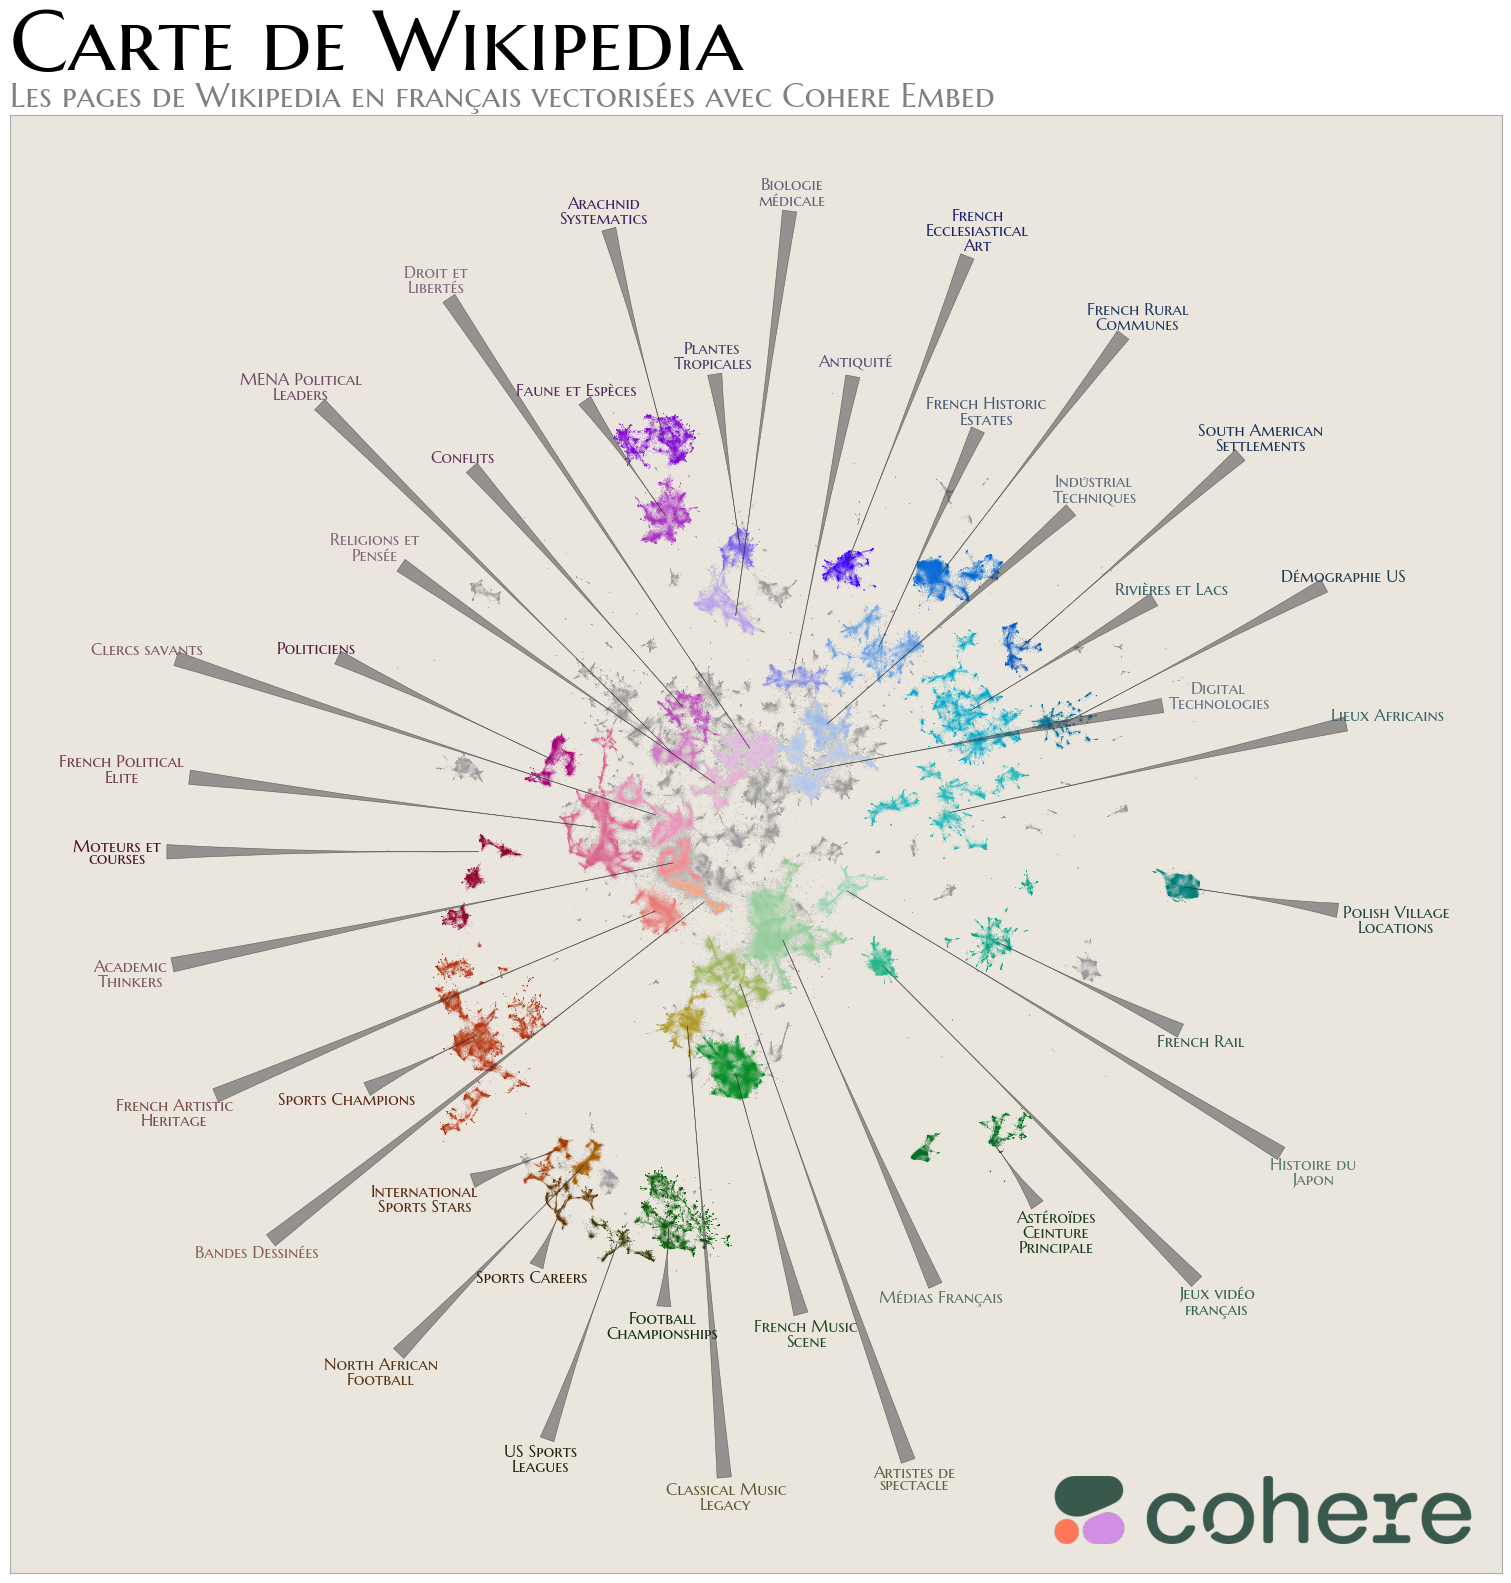

In [27]:
fig, ax = datamapplot.create_plot(
    data_map.astype(np.float32),
    topic_layers[5],
    title="Carte de Wikipedia",
    sub_title="Les pages de Wikipedia en français vectorisées avec Cohere Embed",
    logo=cohere_logo,
    logo_width=0.28,
    use_medoids=True,
    arrowprops={"arrowstyle": "wedge,tail_width=0.85,shrink_factor=0.15", "linewidth": 0.4, "fc": "#33333377", "ec": "#333333aa"},
    font_family="Marcellus SC",
    label_linespacing=1.25,
    label_direction_bias=1.25,
    title_keywords={"fontsize":61.5},
    figsize=(15,15)
)
_ = ax.set(facecolor="#eae6de")

Now we want to make an interactive plot. We can do that as simply as calling ``datamapplot.create_interactive_plot``, but we would like to have more functionality available than the most basic versions will provide. To start with it would be good if hovering over points could actually provide useful information about the page. At the same time, we don't want to have to load the entire content of Wikipedia. We can make do with a compromise -- if we have load in only the titles of all the pages, we can use the Wikipedia API to get extracts for the page on an as-needed basis. To enable this within DataMapPlot we will have to provide (javascript -- because this all has to live client-side) code for how to fetch the data given a page title, how to format the results we'll get back into an HTML tooltip, and what to display in the meantime. Let's define all of that in advance:

In [29]:
api_tooltip = {
    "fetch_js": """
async (identifier) => {
    const apiUrl = `https://fr.wikipedia.org/w/api.php?` +
      `action=query&` +
      `format=json&` +
      `prop=extracts|pageimages&` +
      `exintro=1&` +
      `explaintext=1&` +
      `pithumbsize=300&` +
      `titles=${encodeURIComponent(identifier)}&` +
      `origin=*`;

    const response = await fetch(apiUrl);
    const json = await response.json();
    const page = Object.values(json.query.pages)[0];

    const content = {
      title: page.title,
      extract: page.extract,
      thumbnail: page.thumbnail?.source,
      url: `https://fr.wikipedia.org/wiki/${encodeURIComponent(page.title)}`
    };
    return content;
}
    """,
    "format_js": """
(data) => {
    return `
      <h3 style="margin: 0 0 8px 0">${data.title}</h3>
      ${data.thumbnail ?
        `<img src="${data.thumbnail}"
          style="float: right; max-width: 100px; margin: 0 0 8px 8px;"
          alt="${data.title}"/>`
        : ''}
      <p style="margin: 0; line-height: 1.4;">
        ${data.extract.split('. ').slice(0, 3).join('. ')}.
      </p>
    `;
}
    """,
    "loading_js": """
(identifier) => {
    return `
      <h3 style="margin: 0 0 8px 0">${identifier}</h3>
      Chargement ...
      `
}
    """,
    "error_js": """
(error, identifier) => `Erreur durant le chargement de l'information sur ${identifier}: ${error.message}`
    """,
}

It can also be useful to have word-clouds of the text of selected items appear using lasso-style selections. There is already tooling in DataMapPlot to do this. Unfortunately that tooling is built mostly for smaller datasets than the 5+ million pages of English Wikipedia and assumes that we have all the text content we want to build word-clouds from in memory on the client side (i.e. the text we would be using for tooltips). Since we are fetching text content on-demand for tooltips we will have to do the same for the word-clouds. That means we need a modified ``WordCloud`` selection handler. This is actually a relatively small change to the existing ``WordCloud`` selection handler, so in practice we will grab that code and make the minor modifications required to have it fetch text data rather than assuming it is already in memory.

In [31]:
from datamapplot.selection_handlers import SelectionHandlerBase
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string

from datamapplot.config import ConfigManager
cfg = ConfigManager()

class WikipediaWordCloud(SelectionHandlerBase):
    """A selection handler that generates a word cloud from the selected text items by pulling the
    relevant text from Wikipedia pages with the titles given by the selection. The word cloud
    is displayed in a container on the page, and the number of words in the cloud can be controlled
    by the `n_words` parameter.

    The word cloud is generated using the d3-cloud library, and the appearance of the word cloud can
    be customized using the `width`, `height`, `font_family`, `stop_words`, `n_rotations`, and `color_scale`
    parameters.

    Parameters
    ----------
    n_words : int, optional
        The number of words to display in the word cloud. Default is 256.

    width : int, optional
        The width of the word cloud container. Default is 500.

    height : int, optional
        The height of the word cloud container. Default is 500.

    font_family : str, optional
        The font family to use for the word cloud. Default is None.

    stop_words : list, optional
        A list of stop words to exclude from the word cloud. Default is the English stop words from scikit-learn.

    n_rotations : int, optional
        The number of rotations to use for the words in the word cloud. Default is 0. More rotations can make the
        word cloud more visually interesting, at the cost of readability.

    color_scale : str, optional
        The color scale to use for the word cloud. Default is "YlGnBu". The color scale can be any d3 color scale
        name, with an optional "_r" suffix to reverse the color scale.

    location : str, optional
        The location of the word cloud container on the page. Default is "bottom-right".
        Should be one of "top-left", "top-right", "bottom-left", or "bottom-right".

    **kwargs
        Additional keyword arguments to pass to the SelectionHandlerBase constructor.

    """

    @cfg.complete(unconfigurable={"self", "width", "height", "n_words"})
    def __init__(
        self,
        n_words=256,
        width=500,
        height=500,
        font_family=None,
        stop_words=None,
        n_rotations=0,
        use_idf=False,
        color_scale="YlGnBu",
        location="bottom-right",
        cdn_url="unpkg.com",
        other_triggers=None,
        **kwargs,
    ):
        super().__init__(
            dependencies=[
                f"https://{cdn_url}/d3@latest/dist/d3.min.js",
                f"https://{cdn_url}/d3-cloud@1.2.7/build/d3.layout.cloud.js",
                f"https://{cdn_url}/jquery@3.7.1/dist/jquery.min.js",
            ],
            **kwargs,
        )
        self.n_words = n_words
        self.width = width
        self.height = height
        self.font_family = font_family
        self.stop_words = stop_words or list(ENGLISH_STOP_WORDS)
        self.n_rotations = min(22, n_rotations)
        self.use_idf = str(use_idf).lower()
        self.location = location
        if color_scale.endswith("_r"):
            self.color_scale = string.capwords(color_scale[:1]) + color_scale[1:-2]
            self.color_scale_reversed = True
        else:
            self.color_scale = string.capwords(color_scale[:1]) + color_scale[1:]
            self.color_scale_reversed = False
        self.other_triggers = other_triggers

    @property
    def javascript(self):
        result = f"""
const _STOPWORDS = new Set({self.stop_words});
const _ROTATIONS = [0, -90, 90, -45, 45, -30, 30, -60, 60, -15, 15, -75, 75, -7.5, 7.5, -22.5, 22.5, -52.5, 52.5, -37.5, 37.5, -67.5, 67.5];
let wordCloudStackContainer = document.getElementsByClassName("stack {self.location}")[0];
const wordCloudItem = document.createElement("div");
wordCloudItem.id = "word-cloud";
wordCloudItem.className = "container-box more-opaque stack-box";
wordCloudStackContainer.appendChild(wordCloudItem);

const wordCloudSvg = d3.select("#word-cloud").append("svg")
    .attr("width", {self.width})
    .attr("height", {self.height})
    .append("g")
    .attr("transform", "translate(" + {self.width} / 2 + "," + {self.height} / 2 + ")");

var wordCounter = null;
wordCounter = function (textItems) {{
    const words = textItems.join(' ').toLowerCase().split(/\\s+/);
    const wordCounts = new Map();
    words.forEach(word => {{
        wordCounts.set(word, (wordCounts.get(word) || 0) + 1);
    }});
    _STOPWORDS.forEach(stopword => wordCounts.delete(stopword));
    const result = Array.from(wordCounts, ([word, frequency]) => ({{ text: word, size: Math.sqrt(frequency) }}))
                        .sort((a, b) => b.size - a.size).slice(0, {self.n_words});
    const maxSize = Math.max(...(result.map(x => x.size)));
    return result.map(({{text, size}}) => ({{ text: text, size: (size / maxSize)}}));
}}

// Cache for API responses
const batchCache = new Map();

async function fetchWikiContentBatch(titles, maxTitles = 250) {{
    // Deduplicate and filter already cached titles
    const uniqueTitles = [...new Set(titles)];
    const titlesToFetch = uniqueTitles.filter(title => !batchCache.has(title));

    // Split titles into chunks of 50 (API limit per request)
    const chunks = [];
    for (let i = 0; i < Math.min(titlesToFetch.length, maxTitles); i += 50) {{
        chunks.push(titlesToFetch.slice(i, i + 50));
    }}

    // Process each chunk
    const results = [];

    try {{
        // Fetch all chunks in parallel
        await Promise.all(chunks.map(async (titleChunk) => {{
            const titleString = titleChunk.join('|');
            const apiUrl = `https://fr.wikipedia.org/w/api.php?` +
                `action=query&` +
                `format=json&` +
                `prop=extracts&` +
                `exintro=0&` + // Get full content, not just intro
                `explaintext=1&` +
                `titles=${{encodeURIComponent(titleString)}}&` +
                `origin=*`;

            const response = await fetch(apiUrl);
            const json = await response.json();

            // Process each page in the response
            Object.values(json.query.pages).forEach(page => {{
                // Store in both results and cache
                if (page.extract) {{
                  results.push(page.extract);
                  batchCache.set(page.title, page.extract);
                }} else {{
                  results.push(page.title);
                }}
            }});
        }}));

        // Combine cached and new results
        return results.concat(Array.from(uniqueTitles).filter(title => batchCache.has(title)).map(title => batchCache.get(title)));

    }} catch (error) {{
        console.error('Error fetching Wikipedia content batch:', error);
        return new Map();
    }}
}}

function generateWordCloud(words) {{
  const width = {self.width};
  const height = {self.height};

  const colorScale = d3.scaleSequential(d3.interpolate{self.color_scale}).domain([{"width / 10, 0" if self.color_scale_reversed else "0, width / 10"}]);

  // Configure a cloud layout
  const layout = d3.layout.cloud()
    .size([width, height])
    .words(words.map(d => ({{text: d.text, size: d.size * width / 10}})))
    .padding(1)
    .rotate(() => _ROTATIONS[~~(Math.random() * {self.n_rotations})])
    .font("{self.font_family or 'Impact'}")
    .fontSize(d => d.size)
    .fontWeight(d => Math.max(300, Math.min(d.size * 9000 / width, 900)))
    .on("end", draw);

  layout.start();

  function draw(words) {{
    const t = d3.transition().duration(300);

    // Update existing words
    const text = wordCloudSvg.selectAll("text")
      .data(words, d => d.text);

    // Remove old words
    text.exit()
      .transition(t)
      .attr("fill-opacity", 0)
      .attr("font-size", 1)
      .remove();
    // Add new words
    text.enter()
      .append("text")
      .attr("text-anchor", "middle")
      .attr("fill-opacity", 0)
      .attr("font-size", 1)
      .attr("font-family", "{self.font_family or 'Impact'}")
      .text(d => d.text)
      .merge(text) // Merge enter and update selections
      .transition(t)
      .attr("transform", d => "translate(" + [d.x, d.y] + ")rotate(" + d.rotate + ")")
      .attr("fill-opacity", 1)
      .attr("font-size", d => d.size)
      .attr("font-weight", d => Math.max(300, Math.min(d.size * 9000 / width, 900)))
      .attr("fill", d => colorScale(d.size));
  }}
}}

const shuffle = ([...arr]) => {{
  let m = arr.length;
  while (m) {{
    const i = Math.floor(Math.random() * m--);
    [arr[m], arr[i]] = [arr[i], arr[m]];
  }}
  return arr;
}};
const sampleSize = ([...arr], n = 1) => shuffle(arr).slice(0, n);

async function wordCloudCallback(selectedPoints) {{
    if (selectedPoints.length > 0) {{
        $(wordCloudItem).animate({{height:'show'}}, 250);
    }} else {{
        $(wordCloudItem).animate({{height:'hide'}}, 250);
    }}
    let selectedText;
    if (datamap.metaData) {{
        selectedText = await fetchWikiContentBatch(sampleSize(selectedPoints, 500).map(i => datamap.metaData.hover_text[i]));
    }} else {{
        selectedText = ["Le chargement des métadonnées est en cours..."];
    }}
    const wordCounts = wordCounter(selectedText);
    generateWordCloud(wordCounts);
}}

await datamap.addSelectionHandler(debounce(wordCloudCallback));
"""
        if self.other_triggers:
            for trigger in self.other_triggers:
                result += f"""await datamap.addSelectionHandler(debounce(wordCloudCallback), "{trigger}");\n"""
        return result

    @property
    def html(self):
        # return """<div id="word-cloud" class="container-box more-opaque"></div>"""
        return ""

    @property
    def css(self):
        return f"""
#word-cloud {{
    position: relative;
    display: none;
    width: {self.width}px;
    height: {self.height}px;
    z-index: 10;
}}
"""

In [32]:
from stop_words import get_stop_words
STOP_WORDS_FR = get_stop_words("fr")
pd.Series(STOP_WORDS_FR)

0           a
1          ai
2         aie
3       aient
4        aies
        ...  
242    étions
243       été
244      étés
245      êtes
246      être
Length: 247, dtype: object

It will be good to have an info-box item that a user can click on to have it expand and provide more information about the page. This isn't available by default in DataMapPlot, but we can provide our own custom CSS and javascript, so let's create what we need to allow for a simple clickable info box that has the text content we want.

In [33]:
custom_css = """
#info-box {
    width: fit-content;
    height: fit-content;
    z-index: 10;
    overflow: hidden;
    width: 20px;
    height: 20px;
    display: flex;
    align-items: center;
    justify-content: center;
}

#info-icon {
    display: flex;
    align-items: center;
    justify-content: center;
    width: 100%;
    height: 100%;
}

#info-icon svg {
    width: 16px;
    height: 16px;
}

#info-content {
    display: none;
    position: absolute;
    padding: 12px;
    box-sizing: border-box;
    width: 100%;
    height: 100%;
    overflow-y: auto;
    pointer-events: none;
}

#info-content h3 {
    margin-top: 0;
    margin-bottom: 10px;
    color: #0056b3;
    font-size: 1.1em;
}

#info-content p {
    margin-bottom: 0;
    font-size: 0.9em;
    line-height: 1.2;
}

#info-box.expanded {
    width: 600px;
    height: auto;
    min-height: 100px;
    max-height: 800px;
    border: 1px solid #ccc;
    align-items: flex-start;
    justify-content: flex-start;
    overflow-y: auto;
}

#info-box.expanded #info-icon {
    pointer-events: none;
    display: none;
}

#info-box.expanded #info-content {
    position: relative;
    display: block;
    pointer-events: auto;
}
"""

custom_js = """
const infoWidget = document.createElement("div");
infoWidget.id = "info-box";
infoWidget.className = "container-box more-opaque stack-box";
infoWidget.innerHTML = `
<div id="info-icon">
  <svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 16 16" fill="currentColor">
    <path d="M8 15A7 7 0 1 1 8 1a7 7 0 0 1 0 14zm0 1A8 8 0 1 0 8 0a8 8 0 0 0 0 16z"/>
    <path d="m8.93 6.588-2.29.287-.082.38.45.083c.294.07.352.176.288.469l-.738 3.468c-.194.897.105 1.319.808 1.319.545 0 1.178-.252 1.465-.598l.088-.416c-.2.176-.492.246-.686.246-.275 0-.375-.193-.304-.533L8.93 6.588zM9 4.5a1 1 0 1 1-2 0 1 1 0 0 1 2 0z"/>
  </svg>
</div>
<div id="info-content">
    <h3>À propos de cette <em>carte de données</em></h3>
    <p>
        Cette page constitue une carte explorable de Wikipedia en français.
        Elle a été constuite en utilisant des
        <a href="https://huggingface.co/datasets/Cohere/wikipedia-2023-11-embed-multilingual-v3">plongements
        compilés par Cohere</a>, openTSNE, <a href="https://github.com/TutteInstitute/toponymy">Toponymy</a>,
        ainsi que <a href="https://github.com/TutteInstitute/datamapplot">DataMapPlot</a>.
        Elle existe en tant que vitrine pour certaines des fonctionnalités
        des librairies DataMapPlot et Toponymy.
    </p>
    <p>
        Les étiquettes des sujets ont été générées automatiquement en utilisant
        Toponymy et le LLM Cohere Command-R.
    </p>
    <p>
        Cliquez et glissez pour déplacer la carte, utilisez la roulette de souris ou pincez l'écran pour zoomer.
        Cliquer sur un point naviguera à la page correspondante.<br/>
        L'arbre des sujets (<em>topic tree</em>) facilite le déplacement vers des sujets spécifiques.
        Développez les sujets en cliquant sur le triangle pour révéler des sous-sujets plus précis.
        Cliquez sur le nom d'un sujet pour centrer la vue de la carte sur sa position.<br/>
        En tenant Shift, cliquez et glissez pour sélectionner une région:
        cela générera un <em>nuage de mots</em> à partir du contenu des pages sélectionnées.
        Sélectionnez une région vide pour faire disparaître l'encart du nuage.
    </p>
</div>
`
const stackContainer = document.getElementsByClassName("stack bottom-left")[0];
stackContainer.insertBefore(infoWidget, stackContainer.firstChild);
if (infoWidget) {
    infoWidget.addEventListener('click', function() {
        infoWidget.classList.toggle('expanded');
    });
} else {
    console.error("On ne trouve pas l'élément avec ID 'info-widget'.");
}
"""

Last of all, while we have the word-count of the page, it would be nice to have some other metadata about the pages that we can display (potentially looking at other colourmaps over the data for example). I collected this data for the pages listed in the 2023 pull from Cohere -- counts of incoming links, outgoing links, number of categories the page belongs to, and the number of page-views in the last month. This is simply a matter of using the Wikipedia REST API to query for information; to do this and follow rate-limits etc. is more complicated than worth showing here, and can be quite time-consuming (based on the rate limits and the number of pages we need to query data for). I did all the querying and then saved the dataset and uploaded it to Huggingface datasets for others to use. We can load that data in.

In [34]:
wikipedia_page_stats = pd.read_parquet("hf://datasets/lmcinnes/wikipedia_page_statistics/wikipedia_page_stats.parquet")

Now it is time to make our interactive plot. We will need to provide the data map, all the topic name layers, hover text which is the name of page, and some styling options. To make things a little more interesting we can add search functionality (to search by page title), an on-click action that will take you to the actual Wikipedia page, a selection handler that will pop up a word-cloud based on the contents of the pages selected, the ability to colour points by incoming links, number of categories, or page views, a "table-of-contents" that allows navigation by a tree of topics generated by Toponymy, a splash warning, and our custom tooltip, and info-box. There's quite a lot of data here, and a bunch of work to compile it, so this will take some time.

In [35]:
%%time
wikipedia_plot_bundle = datamapplot.create_interactive_plot(
    data_map,
    *topic_layers,
    hover_text=metadata_fr.titles.values,
    cluster_boundary_polygons=True,
    polygon_alpha=0.1,
    cluster_boundary_line_width=0.2,
    enable_search=True,
    point_radius_min_pixels=0.2,
    point_radius_max_pixels=16,
    point_line_width=0,
    marker_size_array=np.sqrt(metadata_fr.word_counts.values),
    initial_zoom_fraction=0.9,
    font_family="Cinzel",
    title="Carte interactive de Wikipedia",
    sub_title="Une carte des articles en français de Wikipedia. Les articles similaires correspondent à des points rapprochés.",
    logo="https://asset.brandfetch.io/idfDTLvPCK/idyv4d98RT.png",
    on_click="window.open(`https://fr.wikipedia.org/wiki/${{encodeURIComponent(hoverData.hover_text[index])}}`)",
    selection_handler=WikipediaWordCloud(512, width=640, height=480, font_family="Cinzel", stop_words=STOP_WORDS_FR, n_rotations=1, location="top-right"),
    colormap_rawdata=[
        np.log10(1 + wikipedia_page_stats.incoming_link_count),
        np.log10(1 + wikipedia_page_stats.category_count),
        np.log10(1 + wikipedia_page_stats.page_view_count)
    ],
    colormap_metadata=[
        {"field": "inlinks", "description": "Log du nombre de liens antécédents", "cmap": "mako_r", "kind": "continuous"},
        {"field": "categories", "description": "Log du nombre de catégories", "cmap": "rocket_r", "kind": "continuous"},
        {"field": "views", "description": "Log du nombre de visites par mois", "cmap": "YlGn", "kind": "continuous"},
    ],
    enable_topic_tree=True,
    topic_tree_kwds={"color_bullets": True},
    splash_warning="<p>Cette page va télécharger environ 200MB de données pour construire une carte interactive de Wikipedia.</p><p>Ce chargement initial peut prendre un bon moment...</p>",
    inline_data=False,
    offline_data_chunk_size=400_000,
    dynamic_tooltip=api_tooltip,
    custom_js=custom_js,
    custom_css=custom_css,
)

CPU times: user 11min 13s, sys: 14.7 s, total: 11min 27s
Wall time: 9min 52s


With that done all we have to do is save the results. Since this is a lot of data the files are chunked up, and our best approach is to use the ``save_bundle`` method that will put all the relevant material into a single zip file. You can then unzip that file on a webserver (or unzip it locally and run a local server with ``python -m http.server -b 127.0.0.1 8080`` or similar) and be good to go. If you are not worried about having a hideously large single HTML file that you can just view locally, simply comment out the lines

```python
    inline_data=False,
    offline_data_chunk_size=400_000,
```

from the above cell, rerun, and then use

```python
wikipedia_plot_bundle.save('wikipedia_data_map.html')
```

In [36]:
wikipedia_plot_bundle.save_bundle('wikipedia-fr_data_map.zip')

Adding datamapplot_point_data_0.zip to bundle
Adding datamapplot_point_data_1.zip to bundle
Adding datamapplot_point_data_2.zip to bundle
Adding datamapplot_point_data_3.zip to bundle
Adding datamapplot_point_data_4.zip to bundle
Adding datamapplot_point_data_5.zip to bundle
Adding datamapplot_meta_data_0.zip to bundle
Adding datamapplot_meta_data_1.zip to bundle
Adding datamapplot_meta_data_2.zip to bundle
Adding datamapplot_meta_data_3.zip to bundle
Adding datamapplot_meta_data_4.zip to bundle
Adding datamapplot_meta_data_5.zip to bundle
Adding datamapplot_label_data.zip to bundle
Adding datamapplot_color_data_0.zip to bundle
Adding datamapplot_color_data_1.zip to bundle
Adding datamapplot_color_data_2.zip to bundle
Adding datamapplot_color_data_3.zip to bundle
Adding datamapplot_color_data_4.zip to bundle
Adding datamapplot_color_data_5.zip to bundle
